In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import os
os.makedirs("../out", exist_ok=True)

from tqdm import tqdm

## Q1.2: Lucas-Kanade Tracking

Make sure to comment your code and use proper names for your variables. 

In [2]:
# We recommend using this function, but you can explore other methods as well (e.g., ndimage.shift).
from scipy.interpolate import RectBivariateSpline

# The function below could be useful as well :) 
# from numpy.linalg import lstsq

def LucasKanade(It, It1, rect, threshold, num_iters, p0=np.zeros(2)):
    """
    :param[np.array(H, W)] It   : Image frame at time-step t
    :param[np.array(H, W)] It1  : Image frame at time-step t+1
    :param[np.array(4, 1)] rect : Coordinates of template which has the form [x1, y1, x2, y2], where
                                  [x1, y1] is the top-left, and [x2, y2] is the bottom-right corner.  
    :param[float] dp_thresh     : If the length of dp < threshold, terminate the optimization
    :param[int] num_iters       : Number of iterations for running the optimization
    :param[np.array(2, 1)] p0   : Initial movement vector [dp_x0, dp_y0]

    :return[np.array(2, 1)] p   : Final movement vector [dp_x, dp_y]
    """
    # Initialize p to p0. Don't remove these lines.
    p = p0
    delta_p = np.ones((1,2))

    # TODO: Add your LK implementation here:
    def threshcheck(pval):
        return np.linalg.norm(pval, ord=2)**2 < threshold

    x1, y1, x2, y2 = rect
    Ityvals, Itxvals = np.arange(It.shape[0]), np.arange(It.shape[1])
    It1yvals, It1xvals = np.arange(It1.shape[0]), np.arange(It1.shape[1])
    Itfn = RectBivariateSpline(Ityvals, Itxvals, It)
    It1fn = RectBivariateSpline(It1yvals, It1xvals, It1)

    x = np.arange(x1, x2 + 1)
    y = np.arange(y1, y2 + 1)

    x, y = np.meshgrid(x, y)
    x = x.flatten()
    y = y.flatten()
    # x, y coords of template needs to be converted to follow numpy convention
    template = Itfn.ev(y, x)[:, np.newaxis] 

    for _ in range(num_iters):
        # warp the image
        xhat = x + p[0]
        yhat = y + p[1]
        
        # It1 gradients along x and y
        Ix = It1fn.ev(yhat, xhat, dy=1, dx=0)[:, np.newaxis] # scipy x, y axis is normal convention
        Iy = It1fn.ev(yhat, xhat, dy=0, dx=1)[:, np.newaxis]
        
        # build the A matrix
        A = np.hstack((Ix, Iy))
        
        # build the b vector
        It1template = It1fn.ev(yhat, xhat)[:, np.newaxis]
        b = template - It1template
        
        # solve linear system of equations
        dp = np.linalg.lstsq(A, b, rcond=None)[0].squeeze(axis=1)
        p = p + dp
        if threshcheck(dp):
            break
    return p

### Debug Q1.2 

A few tips to debug your implementation:
- You can use the short snippet of code below to test if you get reasonable results. The snippet simply 
checks visualizes the resulting p from running LK on a single frame. You should be able to see a slight shift in the template. 

- You may also want to visualize the image gradients you compute within your LK implementation

- Plot iterations vs the norm of delta_p

86 35


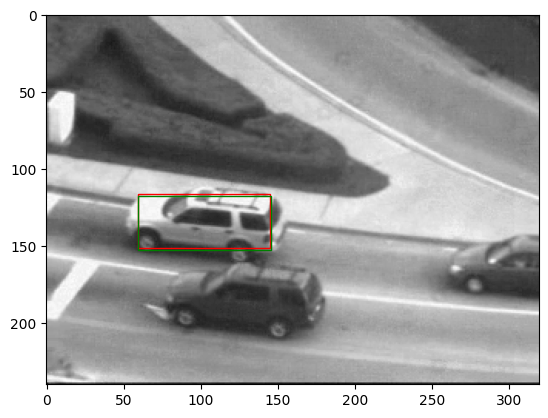

In [3]:
num_iters = int(1e4)
threshold = 0.01
seq = np.load("../data/carseq.npy")
rect = [59, 116, 145, 151]
It = seq[:,:,0]
w = rect[2] - rect[0]
h = rect[3] - rect[1]
print(w, h)

# Initial frame
plt.figure()
currentAxis = plt.gca()
rect_draw_It1 = patches.Rectangle((rect[0], rect[1]), w, h, linewidth=1, edgecolor='r', facecolor='none')
currentAxis.add_patch(rect_draw_It1)

# TODO: run LK and update template and plot 
It1  = seq[:, :, 1]
p = LucasKanade(It, It1, rect, threshold, num_iters, p0=np.zeros(2))
new_rect = [rect[0] + p[0], rect[1] + p[1], rect[2] + p[0], rect[3] + p[1]]
new_w = new_rect[2] - new_rect[0]
new_h = new_rect[3] - new_rect[1]
rect_draw_It1 = patches.Rectangle((new_rect[0], new_rect[1]), new_w, new_h, linewidth=1, edgecolor='g', facecolor='none')

currentAxis.add_patch(rect_draw_It1)
plt.imshow(It1, cmap='gray')
plt.show()

## Q1.3: Track Sequence

In [4]:
def TrackSequence(seq, rect, num_iters, threshold):
    """
    :param[np.array(H, W, N)] seq : sequence of frames
    :param[np.array(4, 1)] rect   : Coordinates of template which has the form [x1, y1, x2, y2], where
                                    [x1, y1] is the top-left, and [x2, y2] is the bottom-right corner.  
    :param[int] num_iters         : Number of iterations for running the optimization
    :param[float] dp_thresh       : If the length of dp < threshold, terminate the optimization

    :return[np.array(N, 4)] rects : Coordinates for the template at each frame in the sequence.
    """
    H, W, N = seq.shape

    rects =[rect]
    p = np.zeros(2)
    # TODO: Iterate over the sequence to track the object in of interest. Add your code here:
    for i in tqdm(range(1, seq.shape[2])):
        It = seq[:, :, i - 1]
        It1 = seq[:, :, i]
        p = LucasKanade(It, It1, rect, threshold, num_iters)
        rect = [rect[0] + p[0], rect[1] + p[1], rect[2] + p[0], rect[3] + p[1]]
        rects.append(rect)

    rects = np.array(rects)
    
    # Just a sanity check
    assert rects.shape == (N, 4), f"Your output sequence {rects.shape} is not {N}x{4}"
    return rects

### Q1.3: Track Car Sequence

Feel free to play with these snippets of code; run ablations, visualize a gif with the whole sequence, etc.

Just make sure the bounding boxes for the car are clearly visible, and report those of the frames we requested. 

In [5]:
seq = np.load("../data/carseq.npy")

# TODO: update
rect = [59, 116, 145, 151]

# NOTE: these are default parameters. Once your code works, you're encouraged to play with them by
# running ablations, and report your best results. 
num_iters = int(1e4)
threshold = 1e-2

rects = TrackSequence(seq, rect, num_iters, threshold)
np.save(f'../out/carseqrects.npy', rects)

100%|██████████| 414/414 [00:07<00:00, 55.83it/s]


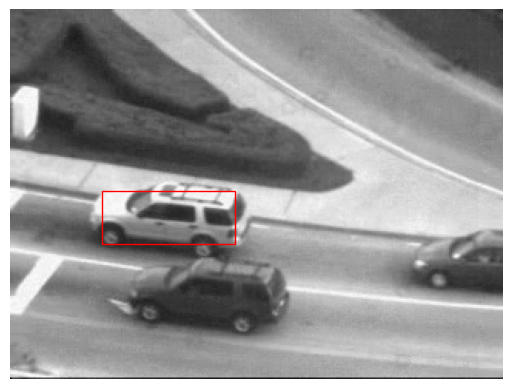

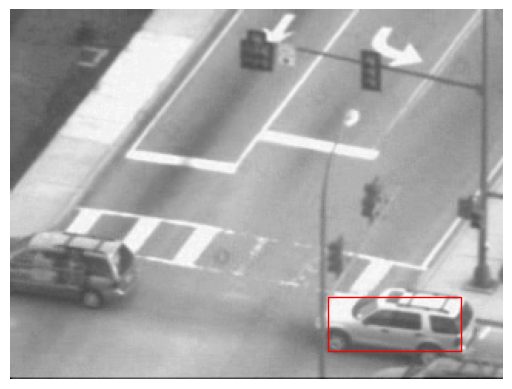

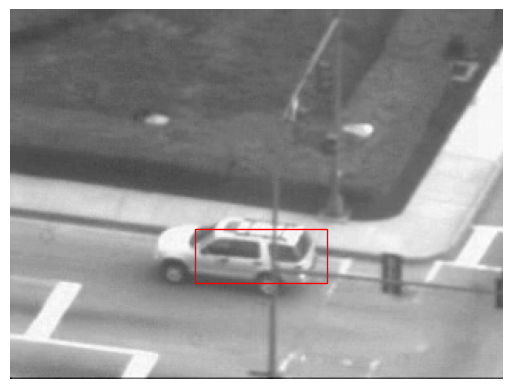

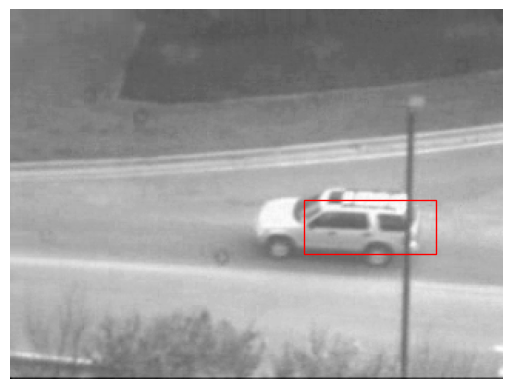

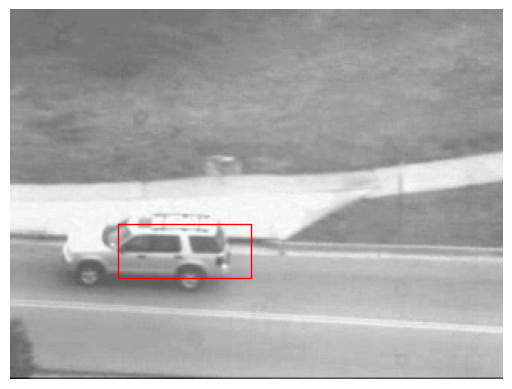

In [6]:
# TODO: visualize. You can make this into a function to re-use it for other visualization questions. 
# List of frames to save
seq = np.load("../data/carseq.npy")
carsseqrects = np.load("../out/carseqrects.npy")
frames_to_save = [1, 80, 160, 280, 410]
for idx in frames_to_save:
    # NOTE: here's an example on how to visualize a frame with its template. 
    frame = seq[:, :, idx]
    rect = carsseqrects[idx]
    w = rect[2] - rect[0]
    h = rect[3] - rect[1]
    plt.figure()
    axis = plt.gca()
    rect_draw = patches.Rectangle(
        (rect[0], rect[1]), w, h, linewidth=1, edgecolor='r', facecolor='none')
    axis.add_patch(rect_draw)
    plt.imshow(frame, cmap='gray')
    plt.axis('off')
    plt.savefig(f"../out/sol_1.3_carseq_{idx+1}.png")

### Q1.3: Test Girl Sequence

Same drill as with the car sequence. 

In [8]:
seq = np.load("../data/girlseq.npy")

# TODO: update
rect = [280, 152, 330, 318]

# NOTE: these are default parameters. Once your code works, you're encouraged to play with them by
# running ablations, and report your best results. 
num_iters = int(1e4)
threshold = 1e-2

rects = TrackSequence(seq, rect, num_iters, threshold)
np.save(f'../out/girlseqrects.npy', rects)

100%|██████████| 89/89 [00:06<00:00, 12.82it/s]


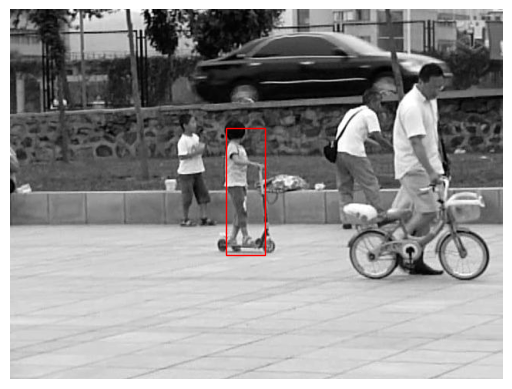

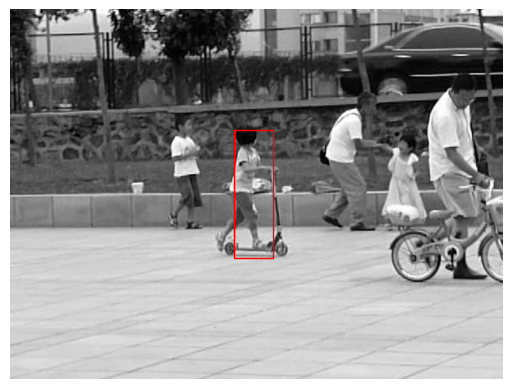

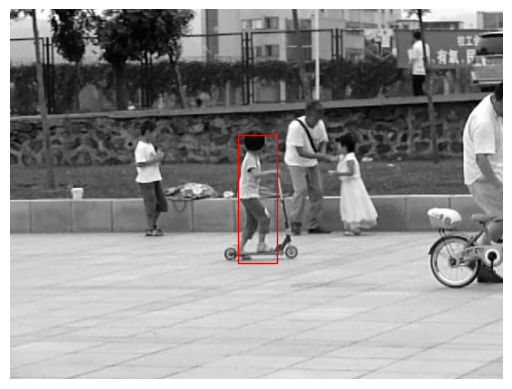

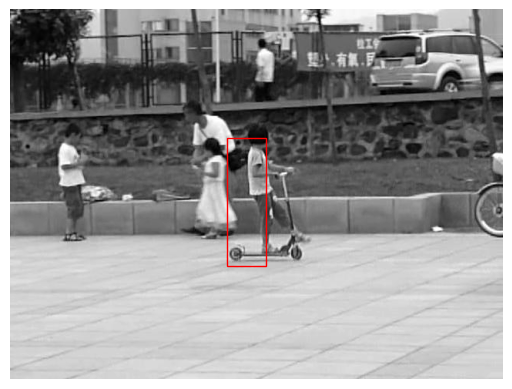

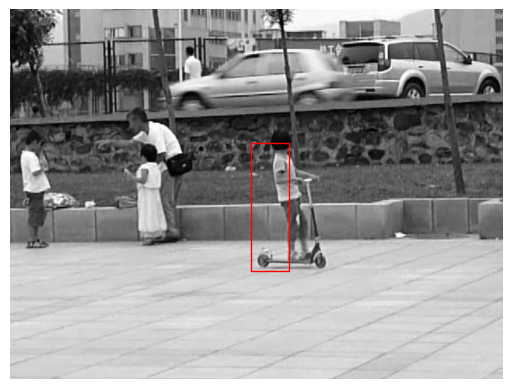

In [9]:
# TODO: visualize. You can copy-and-paste your visualization code from before (or re-use the function)
seq = np.load("../data/girlseq.npy")
girlseqrects = np.load("../out/girlseqrects.npy")
frames_to_save = [1, 15, 35, 65, 85]
for idx in frames_to_save:
    # NOTE: here's an example on how to visualize a frame with its template. 
    frame = seq[:, :, idx]
    rect = girlseqrects[idx]
    w = rect[2] - rect[0]
    h = rect[3] - rect[1]
    plt.figure()
    axis = plt.gca()
    rect_draw = patches.Rectangle(
        (rect[0], rect[1]), w, h, linewidth=1, edgecolor='r', facecolor='none')
    axis.add_patch(rect_draw)
    plt.imshow(frame, cmap='gray')
    plt.axis('off')
    plt.savefig(f"../out/sol_1.3_girlseq_{idx+1}.png")

## Q1.4: Tracking with Template Correction 

In [10]:
def TrackSequenceWithTemplateCorrection(seq, rect_0, num_iters, lk_threshold, drift_threshold):
    """
    :param[np.array(H, W, N)] seq : sequence of frames
    :param[np.array(4, 1)] rect   : Coordinates of template which has the form [x1, y1, x2, y2], where
                                    [x1, y1] is the top-left, and [x2, y2] is the bottom-right corner.  
    :param[int] num_iters         : Number of iterations for running the optimization
    :param[float] dp_thresh       : If the length of dp < threshold, terminate the optimization
    :param[float] drift_threshold : float, threshold for the template update.

    :return[np.array(N, 4)] rects : Coordinates for the template at each frame in the sequence.
    """
    H, W, N = seq.shape
    rect = np.copy(rect_0)
    rects_wtcr =[rect_0]
    
    # It = seq[:, :, 0]
    It0 = seq[:, :, 0]

    # TODO: Iterate over the sequence to track the object in of interest and do template correction.
    for i in tqdm(range(1, seq.shape[2])):
        It1 = seq[:, :, i]
        # compare template from prev frame
        p = LucasKanade(seq[:, :, i - 1], It1, rect, lk_threshold, num_iters, p0=np.zeros(2))

        p0 = np.array([rect[0] + p[0] - rect_0[0], rect[1] + p[1] - rect_0[1]])

        # compare template from 0th frame
        pstar = LucasKanade(It0, It1, rect_0, lk_threshold, num_iters, p0=p0)
        
        if np.linalg.norm(pstar - p, ord=2) <= drift_threshold:
            # drift didn't happen update template
            rect = [rect[0] + p[0], rect[1] + p[1], rect[2] + p[0], rect[3] + p[1]]
        else:
            # drift happened
            rect = [rect_0[0] + pstar[0], rect_0[1] + pstar[1], rect_0[2] + pstar[0], rect_0[3] + pstar[1]]
        
        rects_wtcr.append(rect)

    rects_wtcr = np.array(rects_wtcr)
    
    # Just a sanity check
    assert rects_wtcr.shape == (N, 4), f"Your output sequence {rects_wtcr.shape} is not {N}x{4}"
    return rects_wtcr

### Q1.4: Track Car Sequence with Template Correction

Feel free to play with these snippets of code; run ablations, visualize a gif with the whole sequence, etc.

Just make sure the bounding boxes for the car are clearly visible, and report those of the frames we requested. 

In [11]:
seq = np.load("../data/carseq.npy")

# TODO: update
rect = [59, 116, 145, 151]

# NOTE: these are default parameters. Once your code works, you're encouraged to play with them by
# running ablations, and report your best results. 
num_iters = int(1e4)
threshold = 1e-2
drift_threshold = 5

rects = TrackSequenceWithTemplateCorrection(seq, rect, num_iters, threshold, drift_threshold)
np.save("../out/carseqrects-wtcr.npy", rects)

100%|██████████| 414/414 [00:11<00:00, 36.05it/s]


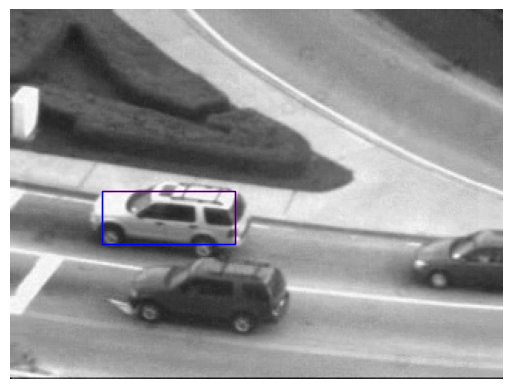

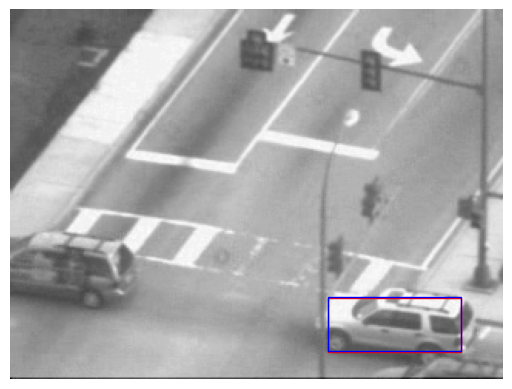

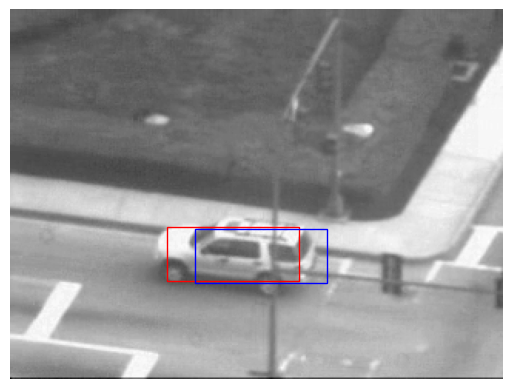

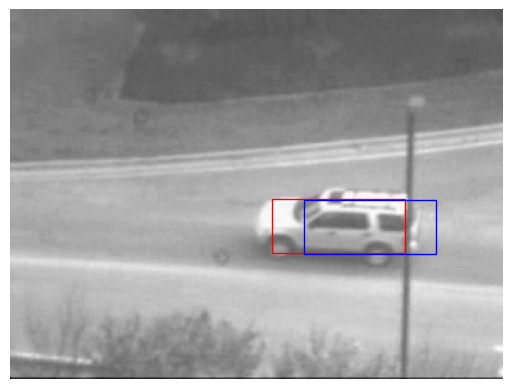

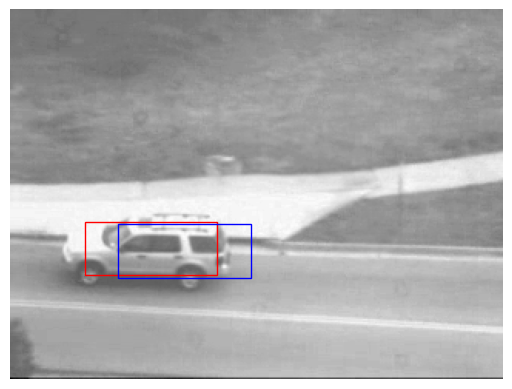

In [12]:
# TODO: visualize. An example for how to visualize the outputs
# List of frames to visualize
seq = np.load("../data/carseq.npy")
frames_to_save = [1, 80, 160, 280, 410]

rects_wtcr = np.load("../out/carseqrects-wtcr.npy")
rects = np.load("../out/carseqrects.npy")

for idx in frames_to_save:
    rect_wtcr = rects_wtcr[idx]
    rect = rects[idx]
    frame = seq[:, :, idx]

    plt.figure()
    currentAxis = plt.gca()
    w = rect[2] - rect[0]
    h = rect[3] - rect[1]
    rect_wcrt_draw = patches.Rectangle(
        (rect_wtcr[0], rect_wtcr[1]), w, h, linewidth=1, edgecolor='r', facecolor='none')
    currentAxis.add_patch(rect_wcrt_draw)
    
    rect_draw = patches.Rectangle(
        (rect[0], rect[1]), w, h, linewidth=1, edgecolor='b', facecolor='none')
    currentAxis.add_patch(rect_draw)
    
    plt.imshow(frame, cmap='gray')
    plt.axis('off')
    plt.savefig(f"../out/sol_1.4_carseq_{idx+1}.png")

### Q1.4: Track Girl Sequence with Template Correction

Feel free to play with these snippets of code; run ablations, visualize a gif with the whole sequence, etc.

Just make sure the bounding boxes for the car are clearly visible, and report those of the frames we requested. 

In [13]:
seq = np.load("../data/girlseq.npy")

# TODO: update
rect = [280, 152, 330, 318]

# NOTE: these are default parameters. Once your code works, you're encouraged to play with them by
# running ablations, and report your best results. 
num_iters = int(1e4)
threshold = 1e-2
drift_threshold = 5

rects = TrackSequenceWithTemplateCorrection(seq, rect, num_iters, threshold, drift_threshold)
np.save("../out/girlseqrects-wtcr.npy", rects)

100%|██████████| 89/89 [00:13<00:00,  6.61it/s]


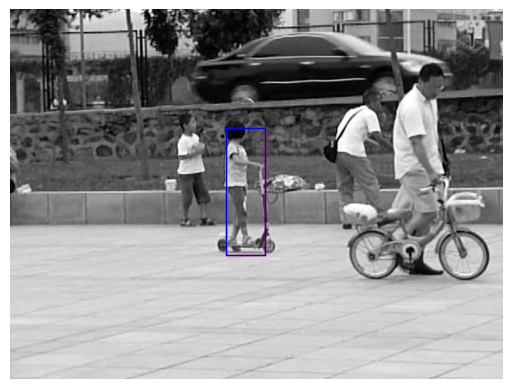

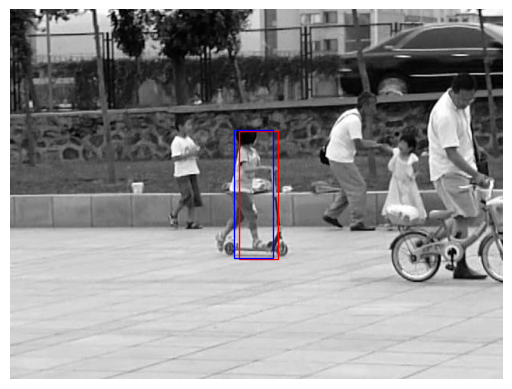

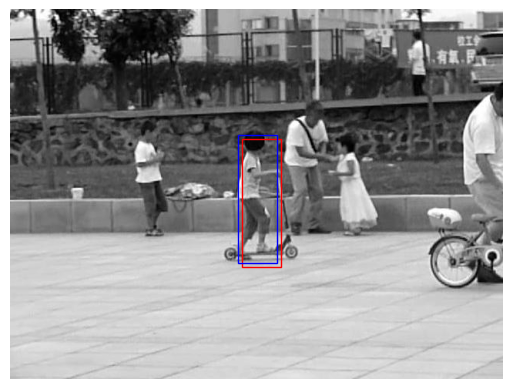

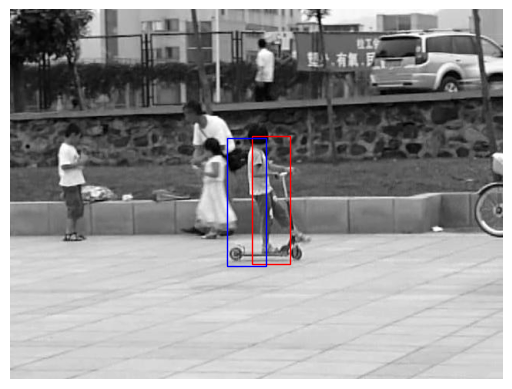

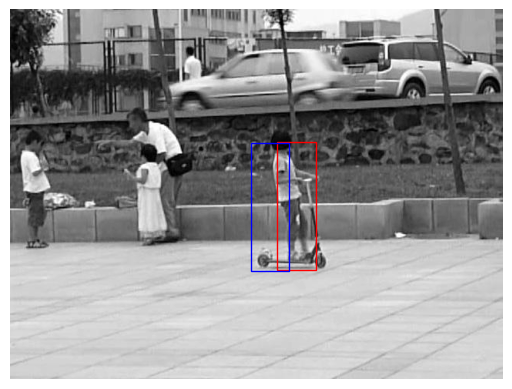

In [14]:
# TODO: visualize. An example for how to visualize the outputs
# List of frames to visualize
seq = np.load("../data/girlseq.npy")
frames_to_save = [1, 15, 35, 65, 85]

rects_wtcr = np.load("../out/girlseqrects-wtcr.npy")
rects = np.load("../out/girlseqrects.npy")

for idx in frames_to_save:
    rect_wtcr = rects_wtcr[idx]
    rect = rects[idx]
    frame = seq[:, :, idx]

    plt.figure()
    currentAxis = plt.gca()
    w = rect[2] - rect[0]
    h = rect[3] - rect[1]
    rect_wcrt_draw = patches.Rectangle(
        (rect_wtcr[0], rect_wtcr[1]), w, h, linewidth=1, edgecolor='r', facecolor='none')
    currentAxis.add_patch(rect_wcrt_draw)
    
    rect_draw = patches.Rectangle(
        (rect[0], rect[1]), w, h, linewidth=1, edgecolor='b', facecolor='none')
    currentAxis.add_patch(rect_draw)
    
    plt.imshow(frame, cmap='gray')
    plt.axis('off')
    plt.savefig(f"../out/sol_1.4_girlseq_{idx+1}.png")